In [212]:
%matplotlib inline

#import notebook
#from notebook.nbextensions import enable_nbextension
#enable_nbextension('notebook', 'usability/codefolding/main')
import numpy as np
import matplotlib.pyplot as mp
import pandas as pd
from scipy.optimize import curve_fit
import seaborn as sns
import markdown
#import scipy.stats as stats
import sys
sys.path.append('/Users/vs/Dropbox/Python')
#import itertools
import glob
import re
import os


#import reddening_laws as red
bigfontsize=20
labelfontsize=16
tickfontsize=16
sns.set_context('talk')
plt.rcParams.update({'font.size': bigfontsize,
                     'axes.labelsize':labelfontsize,
                     'xtick.labelsize':tickfontsize,
                     'ytick.labelsize':tickfontsize,
                     'legend.fontsize':tickfontsize,
                     })

In [213]:
## Read in the data from the gloess output files 
# do this every time so rather than from a fixed file so I can update on a star by star basis

files = glob.glob('/Users/vs/Dropbox/SMC/av_mags/*.glo_avs')

band = []
period = []
mag = []
err = []
cepid = []
cepname = []
vmag = []
imag = []
ident = []


## SMC SPECIFIC
## Want to neglect and VI data in the avs files if OGLE data is available.
## OGLE did not go through gloess -- is in a separate file

## Read in the OGLE data first. If it has m=99.999 then can overwrite that mag with 
## the gloess one if it's available.

## Need to add something to fix it if no V or I mag available so the 99s don't
## mess up the averages.

for line in open("/Users/vs/Dropbox/SMC/av_mags/ogle_mags","r"):
    data = line.split()
    cepname.append(data[0])
    imag.append(float(data[1]))
    vmag.append(float(data[2]))


for name in files:
    splitname = name.split('/')
    cepid.append(re.sub('.glo_avs', '', splitname[-1]))
    #print cepid
    for line in open(name,'r'):
        data = line.split()
        if data[3] != '=' and data[3] != 'std':
        ## Need to remove the extra characters with regex -- re module
            splitname = name.split('/')
            ident.append(re.sub('.glo_avs', '', splitname[-1]))
            band.append(re.sub('[\[\]<>]', '', data[3]))
            period.append(float(data[2]))
            mag.append(float(data[5]))
            if data[7] != 'single':
                err.append(float(data[9]))
            else:
                err.append(0.1)

ident = np.array(ident)
cepname = np.array(cepname)
cepid = np.array(cepid)
imag = np.array(imag)
vmag = np.array(vmag)
period = np.array(period)
mag = np.array(mag)
err = np.array(err)
band = np.array(band)

In [214]:
#ident

In [215]:
tident = []
tband = []
tperiod = []
tmag = []
terr = []

## Want to check to see if the data exists, overwrite if it does, append if not

for count in range(0,cepname.size):
    if imag[count] < 99.:
        if mag[(ident==cepname[count]) & (band=='I')].size == 1:
            mag[(ident==cepname[count]) & (band=='I')] = imag[count]
            err[(ident==cepname[count]) & (band=='I')] = 0.1
        if mag[(ident==cepname[count]) & (band=='I')].size == 0:
            tident.append(cepname[count])
            tband.append("I")
            tperiod.append(period[(ident==cepname[count]) & (band=='3.6')])
            tmag.append(imag[count])
            terr.append(0.1)
    if vmag[count] < 99.:
        if mag[(ident==cepname[count]) & (band=='V')].size == 1:
            mag[(ident==cepname[count]) & (band=='V')] = vmag[count]
            err[(ident==cepname[count]) & (band=='V')] = 0.1
        if mag[(ident==cepname[count]) & (band=='V')].size == 0:
            tident.append(cepname[count])
            tband.append("V")
            tperiod.append(period[(ident==cepname[count]) & (band=='3.6')])
            tmag.append(vmag[count])
            terr.append(0.1)

tident = np.array(tident)
tband = np.array(tband)
tperiod = np.array(tperiod)
tmag = np.array(tmag)
terr = np.array(terr)


#print len(tident), len(tband), len(tperiod), len(tmag), len(terr)

#print len(ident), len(band), len(period), len(mag), len(err)

In [216]:
newident = np.append(ident, tident)
newband = np.append(band, tband)
newperiod = np.append(period, tperiod)
newmag = np.append(mag, tmag)
newerr = np.append(err, terr)

ident = newident
band = newband
period = newperiod
mag = newmag
err = newerr

#print len(ident), len(band), len(period), len(mag), len(err)

In [217]:
logp = np.log10(period)


In [218]:
## Fit the PL relations
## B - I Fouque 2007
## JHK Persson
## IRAC CHP 

def plu(lp, slopeu, zpu):
    return slopeu*(lp - 1.0) + zpu
def plb(lp, zpb):
    return -2.393 * (lp - 1.0) + zpb
def plv(lp, zpv):
    return -2.734 * (lp - 1.0) + zpv
def plr(lp, zpr):
    return -2.742 * (lp - 1.0) + zpr
def pli(lp, zpi):
    return -2.957 * (lp - 1.0) + zpi
def plj(lp, zpj):
    return -3.153 * (lp - 1.0) + zpj
def plh(lp, zph):
    return -3.234 * (lp - 1.0) + zph
def plk(lp, zpk):
    return -3.281 * (lp - 1.0) + zpk
def pl1(lp, zp1):
    return -3.306 * (lp - 1.0) + zp1
def pl2(lp, zp2):
    return -3.207 * (lp - 1.0) + zp2

In [219]:
## U band fitting both coefficients
popt, pcov = curve_fit(plu,logp[(band=='U') & (logp<2.0) & (logp>0.77815) ],mag[(band=='U') & (logp< 2.0) & (logp>0.77815)])
slopeu = popt[0]
zpu = popt[1]
eslopeu = np.sqrt(float(pcov[0][0]))
ezpu = np.sqrt(float(pcov[1][1]))

popt, pcov = curve_fit(plb,logp[(band=='B') & (logp<2.0) & (logp>0.77815) ],mag[(band=='B') & (logp< 2.0) & (logp>0.77815)])
zpb = popt[0]
ezpb = np.sqrt(float(pcov[0]))
popt, pcov = curve_fit(plv,logp[(band=='V') & (logp<2.0) & (logp>0.77815)],mag[(band=='V') & (logp< 2.0) & (logp>0.77815)])
zpv = popt[0]
ezpv = np.sqrt(float(pcov[0]))
popt, pcov = curve_fit(plr,logp[(band=='R') & (logp<2.0) & (logp>0.77815)],mag[(band=='R') & (logp< 2.0) & (logp>0.77815)])
zpr = popt[0]
ezpr = np.sqrt(float(pcov[0]))
popt, pcov = curve_fit(pli,logp[(band=='I') & (logp<2.0) & (logp>0.77815)],mag[(band=='I') & (logp< 2.0) & (logp>0.77815)])
zpi = popt[0]
ezpi = np.sqrt(float(pcov[0]))
popt, pcov = curve_fit(plj,logp[(band=='J') & (logp<2.0) & (logp>0.77815)],mag[(band=='J') & (logp< 2.0) & (logp>0.77815)])
zpj = popt[0]
ezpj = np.sqrt(float(pcov[0]))
popt, pcov = curve_fit(plh,logp[(band=='H') & (logp<2.0) & (logp>0.77815)],mag[(band=='H') & (logp< 2.0) & (logp>0.77815)])
zph = popt[0]
ezph = np.sqrt(float(pcov[0]))
popt, pcov = curve_fit(plk,logp[(band=='K') & (logp<2.0) & (logp>0.77815)],mag[(band=='K') & (logp< 2.0) & (logp>0.77815)])
zpk = popt[0]
ezpk = np.sqrt(float(pcov[0]))
popt, pcov = curve_fit(pl1,logp[(band=='3.6') & (logp<2.0) & (logp>0.77815)],mag[(band=='3.6') & (logp< 2.0) & (logp>0.77815)])
zp1 = popt[0]
ezp1 = np.sqrt(float(pcov[0]))
popt, pcov = curve_fit(pl2,logp[(band=='4.5') & (logp<2.0) & (logp>0.77815)],mag[(band=='4.5') & (logp< 2.0) & (logp>0.77815)])
zp2 = popt[0]
ezp2 = np.sqrt(float(pcov[0]))


In [220]:
## Setting up fits for plotting

lp1 = np.arange(0,3.0,0.1)

plufit = slopeu*(lp1 - 1.0) + zpu
plbfit = -2.393*(lp1 - 1.0) + zpb
plvfit = -2.734 * (lp1 - 1.0) + zpv
plrfit = -2.742 * (lp1 - 1.0) + zpr
plifit = -2.957 * (lp1 - 1.0) + zpi
pljfit = -3.153 * (lp1 - 1.0) + zpj
plhfit = -3.234 * (lp1 - 1.0) + zph
plkfit = -3.281 * (lp1 - 1.0) + zpk
pl1fit = -3.306 * (lp1 - 1.0) + zp1
pl2fit = -3.207 * (lp1 - 1.0) + zp2


In [221]:
## Calculate the standard deviations

deviationsu = plb(logp[(band=='U') & (logp<2.0) & (logp>0.77815)],zpb) - mag[(band=='U') & (logp< 2.0) & (logp>0.77815)]
devusq = deviationsu**2
sdevu = np.sqrt((1./float(np.size(mag[(band=='U') & (logp< 2.0) & (logp>0.77815)])))*sum(devusq))

deviationsb = plb(logp[(band=='B') & (logp<2.0) & (logp>0.77815)],zpb) - mag[(band=='B') & (logp< 2.0) & (logp>0.77815)]
devbsq = deviationsb**2
sdevb = np.sqrt((1./float(np.size(mag[(band=='B') & (logp< 2.0) & (logp>0.77815)])))*sum(devbsq))
deviationsv = plv(logp[(band=='V') & (logp<2.0) & (logp>0.77815)],zpv) - mag[(band=='V') & (logp< 2.0) & (logp>0.77815)]
devvsq = deviationsv**2
sdevv = np.sqrt((1./float(np.size(mag[(band=='V') & (logp< 2.0) & (logp>0.77815)])))*sum(devvsq))
deviationsr = plr(logp[(band=='R') & (logp<2.0) & (logp>0.77815)],zpr) - mag[(band=='R') & (logp< 2.0) & (logp>0.77815)]
devrsq = deviationsr**2
sdevr = np.sqrt((1./float(np.size(mag[(band=='R') & (logp< 2.0) & (logp>0.77815)])))*sum(devrsq))
deviationsi = pli(logp[(band=='I') & (logp<2.0) & (logp>0.77815)],zpi) - mag[(band=='I') & (logp< 2.0) & (logp>0.77815)]
devisq = deviationsi**2
sdevi = np.sqrt((1./float(np.size(mag[(band=='I') & (logp< 2.0) & (logp>0.77815)])))*sum(devisq))
deviationsj = plj(logp[(band=='J') & (logp<2.0) & (logp>0.77815)],zpj) - mag[(band=='J') & (logp< 2.0) & (logp>0.77815)]
devjsq = deviationsj**2
sdevj = np.sqrt((1./float(np.size(mag[(band=='J') & (logp< 2.0) & (logp>0.77815)])))*sum(devjsq))
deviationsh = plh(logp[(band=='H') & (logp<2.0) & (logp>0.77815)],zph) - mag[(band=='H') & (logp< 2.0) & (logp>0.77815)]
devhsq = deviationsh**2
sdevh = np.sqrt((1./float(np.size(mag[(band=='H') & (logp< 2.0) & (logp>0.77815)])))*sum(devhsq))
deviationsk = plk(logp[(band=='K') & (logp<2.0) & (logp>0.77815)],zpk) - mag[(band=='K') & (logp< 2.0) & (logp>0.77815)]
devksq = deviationsk**2
sdevk = np.sqrt((1./float(np.size(mag[(band=='K') & (logp< 2.0) & (logp>0.77815)])))*sum(devksq))
deviations1 = pl1(logp[(band=='3.6') & (logp<2.0) & (logp>0.77815)],zp1) - mag[(band=='3.6') & (logp< 2.0) & (logp>0.77815)]
dev1sq = deviations1**2
sdev1 = np.sqrt((1./float(np.size(mag[(band=='3.6') & (logp< 2.0) & (logp>0.77815)])))*sum(dev1sq))
deviations2 = pl2(logp[(band=='4.5') & (logp<2.0) & (logp>0.77815)],zp2) - mag[(band=='4.5') & (logp< 2.0) & (logp>0.77815)]
dev2sq = deviations2**2
sdev2 = np.sqrt((1./float(np.size(mag[(band=='4.5') & (logp< 2.0) & (logp>0.77815)])))*sum(dev2sq))

mub = zpb - 17.356 + 18.48 + 2.393
muv = zpv - 17.052 + 18.48 + 2.734 
mur = zpr - 16.697 + 18.48 + 2.742 
mui = zpi - 16.589 + 18.48 + 2.957
muj = zpj - 16.336 + 18.48 + 3.153
muh = zph - 16.079 + 18.48 + 3.234
muk = zpk - 16.051 + 18.48 + 3.281
mu1 = zp1 -  -5.80
mu2 = zp2 - -5.77

emub = np.sqrt((ezpb**2) + (0.01**2))
emuv = np.sqrt((ezpv**2) + (0.007**2))
emur = np.sqrt((ezpr**2) + (0.020**2))
emui = np.sqrt((ezpi**2) + (0.005**2))
emuj = np.sqrt((ezpj**2) + (0.015**2))
emuh = np.sqrt((ezph**2) + (0.012**2))
emuk = np.sqrt((ezpk**2) + (0.011**2))
emu1 = np.sqrt((ezp1**2) + (0.03**2))
emu2 = np.sqrt((ezp2**2) + (0.03**2))


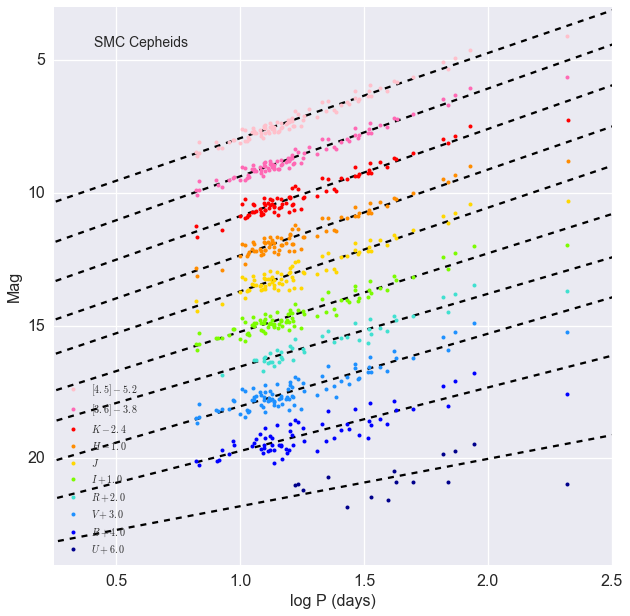

In [222]:
## Plot the relations

mp.clf() 	
mp.figure(figsize=(10, 10))
		
ax1 = mp.subplot(111)
myaxis1 = [0.25,2.5,24,3]
mp.axis(myaxis1)

ax1.plot(lp1,plufit+6.0,'k--')
ax1.plot(logp[band=='U'], mag[band=='U']+6.0,color='DarkBlue',marker='o', ms=4, ls='None', label='$U+6.0$')
ax1.plot(lp1, plbfit+4.0, 'k--')
ax1.plot(logp[band=='B'], mag[band=='B']+4.0,color='Blue',marker='o', ms=4, ls='None', label='$B+4.0$')
ax1.plot(lp1, plvfit+3.0, 'k--')
ax1.plot(logp[band=='V'], mag[band=='V']+3.0,color='DodgerBlue',marker='o', ms=4, ls='None', label='$V+3.0$')
ax1.plot(lp1, plrfit+2.0 ,'k--')
ax1.plot(logp[band=='R'], mag[band=='R']+2.0,color='Turquoise',marker='o', ms=4, ls='None', label='$R+2.0$')
ax1.plot(lp1, plifit+1.0, 'k--')
ax1.plot(logp[band=='I'], mag[band=='I']+1.0,color='LawnGreen',marker='o', ms=4, ls='None', label='$I+1.0$')
ax1.plot(lp1, pljfit, 'k--')
ax1.plot(logp[band=='J'], mag[band=='J'],color='Gold',marker='o', ms=4, ls='None', label='$J$')
ax1.plot(lp1, plhfit-1.0, 'k--')
ax1.plot(logp[band=='H'], mag[band=='H']-1.0,color='DarkOrange',marker='o', ms=4, ls='None', label='$H-1.0$')
ax1.plot(lp1,plkfit-2.4, 'k--')
ax1.plot(logp[band=='K'], mag[band=='K']-2.4,color='Red',marker='o', ms=4, ls='None', label='$K-2.4$')
ax1.plot(lp1,pl1fit-3.8, 'k--')
ax1.plot(logp[band=='3.6'], mag[band=='3.6']-3.8,color='HotPink',marker='o', ms=4, ls='None', label='$[3.6] - 3.8$')
ax1.plot(lp1,pl2fit-5.2, 'k--')
ax1.plot(logp[band=='4.5'], mag[band=='4.5']-5.2,color='Pink',marker='o', ms=4, ls='None', label='$[4.5] - 5.2$')

handles, labels = ax1.get_legend_handles_labels() 
#ax1.legend(handles[::-1],labels[::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., numpoints=1)
ax1.legend(handles[::-1],labels[::-1],loc=3, numpoints=1,prop={'size':10})
ax1.annotate('SMC Cepheids',xy=(0.6, 4.5), xycoords='data', ha='center',fontsize=14)
#plt.gca().invert_yaxis()
mp.xlabel("log P (days)")
mp.ylabel("Mag")
mp.show()


output = 'SMC_PL_relations.pdf'
mp.savefig(output,transparent=True)


In [223]:
## Write the zero-points to a file 

output_zps = open("SMC_pl_relations.txt","w")

print >> output_zps, "PL relation parameters for SMC Cepheids"
print >> output_zps, "Standard relations are from Fouque+ 2007, Persson LMC relations, Monson 2012 MW"
print >> output_zps, "Band, zero--point, zp uncertainty, dispersion, slope, slope uncertainty"

print >> output_zps, "U = {0:.3f} {1:.3f} {2:.3f} {3:.3f} {4:.3f} {5}".format(zpu, ezpu, sdevu, slopeu, eslopeu, np.size(mag[band=='U']))

print >> output_zps, "Band, zero--point, zp uncertainty, dispersion, mu, emu"

print >> output_zps, "B = {0:.3f} {1:.3f} {2:.3f} {3:.2f} {4:.2f} {5}".format(zpb, ezpb, sdevb, mub, emub, np.size(mag[band=='B']))
print >> output_zps, "V = {0:.3f} {1:.3f} {2:.3f} {3:.2f} {4:.2f} {5}".format(zpv, ezpv, sdevv, muv, emuv, np.size(mag[band=='V']))
print >> output_zps, "R = {0:.3f} {1:.3f} {2:.3f} {3:.2f} {4:.2f} {5}".format(zpr, ezpr, sdevr, mur, emur, np.size(mag[band=='R']))
print >> output_zps, "I = {0:.3f} {1:.3f} {2:.3f} {3:.2f} {4:.2f} {5}".format(zpi, ezpi, sdevi, mui, emui, np.size(mag[band=='I']))
print >> output_zps, "J = {0:.3f} {1:.3f} {2:.3f} {3:.2f} {4:.2f} {5}".format(zpj, ezpj, sdevj, muj, emuj, np.size(mag[band=='J']))
print >> output_zps, "H = {0:.3f} {1:.3f} {2:.3f} {3:.2f} {4:.2f} {5}".format(zph, ezph, sdevh, muh, emuh, np.size(mag[band=='H']))
print >> output_zps, "K = {0:.3f} {1:.3f} {2:.3f} {3:.2f} {4:.2f} {5}".format(zpk, ezpk, sdevk, muk, emuk, np.size(mag[band=='K']))
print >> output_zps, "[3.6] = {0:.3f} {1:.3f} {2:.3f} {3:.2f} {4:.2f} {5}".format(zp1, ezp1, sdev1, mu1, emu1, np.size(mag[band=='3.6']))
print >> output_zps, "[4.5] = {0:.3f} {1:.3f} {2:.3f} {3:.2f} {4:.2f} {5}".format(zp2, ezp2, sdev2, mu2, emu2, np.size(mag[band=='4.5']))



In [224]:
df_bigdata = pd.DataFrame({'ID' : ident, 
                           'logP' : logp,
                          'mag' : mag, 
                          'err': err,
                          'band': band})

In [225]:
df_bigdata

,ID,band,err,logP,mag
0,HV00817,3.6,0.024,1.276462,12.094
1,HV00817,4.5,0.023,1.276462,12.063
2,HV00824,U,0.122,1.818411,13.852
3,HV00824,B,0.045,1.818411,13.265
4,HV00824,V,0.023,1.818411,12.426
5,HV00824,R,0.024,1.818411,11.924
6,HV00824,I,0.100,1.818411,11.421
7,HV00824,J,0.037,1.819127,10.882
8,HV00824,H,0.035,1.819127,10.479
9,HV00824,K,0.030,1.819127,10.377


In [226]:
final_table = df_bigdata.pivot(index='ID', columns='band')

#final_table['logP']

In [227]:
my_colnames = []
for i,a in enumerate(final_table.columns.get_level_values(1)):
        my_colnames.append(str(a) + '_' + str(final_table.columns.get_level_values(0)[i]))
final_table.columns = my_colnames
del final_table['U_logP']
del final_table['B_logP']
del final_table['V_logP']
del final_table['R_logP']
del final_table['I_logP']
del final_table['J_logP']
del final_table['H_logP']
del final_table['K_logP']
del final_table['4.5_logP']



In [228]:
final_table.columns
final_table.rename(columns={'3.6_logP': 'logP'}, inplace=True)

In [229]:
outfile = 'smc_multiwavelength_cepheids.txt'
final_table.to_csv(outfile, sep='\t', header=True, index=True, float_format='%8.4f', columns = ('logP', 'U_mag', 'U_err', 'B_mag', 'B_err','V_mag', 'V_err','R_mag', 'R_err','I_mag', 'I_err','J_mag', 'J_err','H_mag', 'H_err','K_mag', 'K_err','3.6_mag', '3.6_err','4.5_mag', '4.5_err'), na_rep=' 99.999')